Training cho delivery speed

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from math import radians, sin, cos, sqrt, atan2
import re


In [43]:

df = pd.read_csv('delivery speed - uds-orders-aug2024.csv')
print("Initial sample size:", df.shape)
df = df.dropna(subset = ['deliveredAt', 'createdAt',])
df['deliveredAt'] = pd.to_datetime(df['deliveredAt'], errors = 'coerce')
df['createdAt'] = pd.to_datetime(df['createdAt'], errors ='coerce')
df = df.dropna(subset=['createdAt', 'deliveredAt'])
print("After deleting:",df.shape)
df['delivery_duration_hours'] = (df['deliveredAt']-df['createdAt']).dt.total_seconds()/3600
df = df[df['delivery_duration_hours'].between(0.1,72)]

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Bán kính Trái đất (km)
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

def extract_district(address):
    if pd.isna(address):
        return "Unknown"
    try: 
       match = re.search(r"(Quận|Q\.?|Huyện|H\.?)\s*([\w\s\dĐđÂâĂăÊêÔôƠơƯư]+)", str(address))
       if match:
           return match.group(0).strip()
    except re.error:
        return "Unknown"
    return "Unknown"
       
if "senderAddress" in df.columns:
    df["sender_district"] = df['senderAddress'].apply(extract_district)
    df['receiver_district'] = df['receiverAddress'].apply(extract_district)
df['hour_of_day'] = df['createdAt'].dt.hour
df['day_of_week'] = df['createdAt'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
le_sender = LabelEncoder()
le_receiver = LabelEncoder()
df['sender_district']= le_sender.fit_transform(df['sender_district'].astype(str))
df['receiver_district'] = le_sender.fit_transform(df['receiver_district'].astype(str))
features = [
    'shippingDistance', 'hour_of_day', 'day_of_week', 'sender_district', 'receiver_district', 'is_weekend'
]
x = df[features]
y = df['delivery_duration_hours']
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test= train_test_split(x_scaled, y, test_size = 0.2, random_state= 42)
model = RandomForestRegressor(n_estimators= 300, random_state= 42, n_jobs = -1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Model trained successfully")
print("\n Model results:")
print(f"MAE: {mae:.3f} hours")
print(f" R2: {r2:2f}")

#predict
def predict_delivery_time(sender_lat, sender_lng, receiver_lat, receiver_lng, created_time, sender_district_name, receiver_district_name):
    dist = haversine(sender_lat, sender_lng, receiver_lat, receiver_lng)
    created_time = pd.to_datetime(created_time)
    hour = created_time.hour
    dow = created_time.dayofweek
    weekend = 1 if dow in [5,6] else 0
    sender_district = le_sender.transform([sender_district_name])[0] if sender_district_name in le_sender.classes_ else 0
    receiver_district = le_receiver.transform([receiver_district_name])[0] if receiver_district_name in le_sender.classes_ else 0
    sample = pd.DataFrame([[dist, hour, dow, sender_district, receiver_district, weekend]], columns = features)
    sample_scaled = scaler.transform(sample)
    pred_hours = model.predict(sample_scaled)[0]
    return pred_hours, 1/pred_hours

pred_time, DS = predict_delivery_time(
    sender_lat = 10.762622, sender_lng = 106.660172,
    receiver_lat = 10.823099, receiver_lng = 106.629662,
    sender_district_name= 'Quận 1',
    receiver_district_name= 'Gò Vấp',
    created_time= "2025-10-16 14:30:00"
)
print(f"\n Dự báo thời gian hàng giao đến: = {pred_time:.2f} giờ")
print(f"Chỉ số tốc độ: = {DS:.3f}")

Initial sample size: (2403, 18)
After deleting: (2395, 18)

 Model trained successfully

 Model results:
MAE: 2.459 hours
 R2: 0.520205

 Dự báo thời gian hàng giao đến: = 26.63 giờ
Chỉ số tốc độ: = 0.038


Training DR

In [31]:
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt


 Model trained successfully
Classification Report:
<function classification_report at 0x000002467C2E74C0> (1666    1
6542    1
6428    0
8060    0
9822    0
       ..
5428    0
8610    1
5664    1
7740    0
961     1
Name: Reached.on.Time_Y.N, Length: 2200, dtype: int64, array([1, 0, 0, ..., 0, 0, 1], shape=(2200,)))


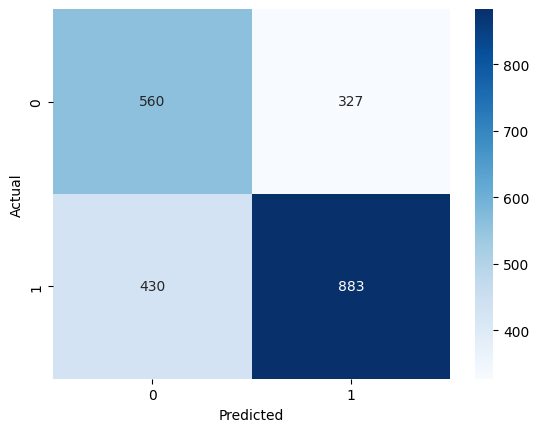

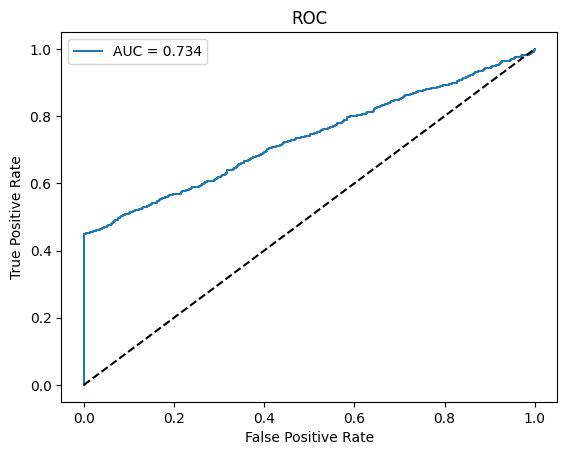

Xác suất đơn hàng giao đúng hẹn: = 99.49%


In [44]:
df = pd.read_csv('delivery reliability - DR.csv')
df = df.dropna()

target = 'Reached.on.Time_Y.N'
x = df.drop(columns = [target])
y = df[target]
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender' ]
numeric_cols = [col for col in x.columns if col not in categorical_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop = 'first'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state= 42, stratify = y)
#pipeline: preprocessing + model
log_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000))
])
#training
log_model.fit(x_train, y_train)
y_pred = log_model.predict(x_test)
y_proba = log_model.predict_proba(x_test)[:,1]

print("\n Model trained successfully")
print("Classification Report:")
print(classification_report, (y_test, y_pred))
results = x_test.copy()
results['Actual'] = y_test.values
results['Prediction_probability_DR'] = y_proba
results.to_csv('result.csv', index = False)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label = f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('ROC')
plt.legend()
plt.show()
new_orders = pd.DataFrame([{
    'ID': 1500,
    'Warehouse_block': 'A',
    'Mode_of_Shipment': 'Road',
    'Customer_care_calls': 5,
    'Customer_rating': 3,
    'Cost_of_the_Product': 200,
    'Prior_purchases': 2,
    'Product_importance': 'medium',
    'Gender': 'M',
    'Discount_offered': 50,
    'Weight_in_gms': 1500,
}])
predicted_prob = log_model.predict_proba(new_orders)[:,1]
print(f"Xác suất đơn hàng giao đúng hẹn: = {predicted_prob[0]:.2%}")

Training DF

In [57]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('delivery flexibility - amazon_delivery.csv')
df.columns = [c.strip() for c in df.columns]

for col in ['Vehicle','Traffic','Weather','Area','Category']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()
    else:
        df[col] = 'unknown'
#mapping
veh_map = {'scooter': 'bike', 'van': 'truck', 'motorcycle': 'motorcycle'}
df['Vehicle'] = df['Vehicle'].map(lambda x:veh_map.get(x,x))
area_map = {'metropolitian':'urban' }
df['Area'] = df['Area'].map(lambda x:area_map.get(x,x))

def normalize_weather(w):
    w = str(w).lower()
    if 'sun' in w: return 'sunny'
    if 'cloud' in w: return 'cloudy'
    if 'sandstorms' in w: return 'stormy'
    return w
df['Weather'] = df['Weather'].map(normalize_weather)

def normalize_traffic(t):
    t = str(t).lower()
    if any(x in t for x in ['jam', 'heavy', 'congest']): return 'jam'
    if any(x in t for x in ['low', 'light']): return 'light'
    if any(x in t for x in ['medium', 'mod']): return 'medium'
df['Traffic'] = df['Traffic'].map(normalize_traffic)

def normalize_cat(c):
    s = str(c).lower()
    if 'frag' in s or 'glass' in s: return 'fragile'
    if 'bulk' in s or 'large' in s: return 'bulky'
    return 'regular'
df['Category'] = df['Category'].map(normalize_cat)

def flexibility_score(row):
    score = 0
    if row['Vehicle'] == 'motorcycle': score +=1
    if row['Area'] == 'urban': score +=1
    if row['Weather'] in ['sunny', 'cloudy']: score +=1
    if row['Traffic'] == 'jam': score -=1
    if row['Category'] in ['fragile','bulky']: score -=1
    if score >=2: return 2
    if score ==1: return 1
    return 0
df['flexibility_score'] = df.apply(flexibility_score, axis = 1)
print("Flexibility distribution:\n", df['flexibility_score'].value_counts().sort_index())

features = ['Vehicle', 'Traffic', 'Area', 'Category', 'Weather']
x = df[features]
y = df['flexibility_score']
encoder = OneHotEncoder(handle_unknown='ignore')
x_enc = encoder.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_enc,y, test_size= 0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs = -1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred))

try:
    feature_names = encoder.get_feature_names_out(features)
    importances = clf.feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
    print("\nTop feature importances:\n", fi.head(10).to_string(index=False))
except Exception as e:
    print("Feature importance error:", e)

#predict
def predict_flexibility(vehicle, traffic, weather, area, category):
    sample = pd.DataFrame([{
        'Vehicle': str(vehicle).strip().lower(),
        'Traffic': str(traffic).strip().lower(),
        'Weather': normalize_weather(weather),
        'Area': str(area).strip().lower(),
        'Category': normalize_cat(category)
    }])      
    for col in features:
        if col not in sample.columns:
            sample[col] = "Unknown"
    sample = sample[features]  
    xs = encoder.transform(sample)
    pred = clf.predict(xs)[0]
    prob = clf.predict_proba(xs)[0]
    df_norm = pred/2
    return {'Flexibility_Score': int(pred), 'DF_normalized': float(df_norm), 'class_probabilities': prob.tolist()}

simulate = predict_flexibility('cloudy', 'light', 'motorcycle', 'urban', 'fragile')
print('Prediction', simulate)
df_sample = df[features + ['flexibility_score']].sample(min(8,len(df)), random_state=42)
df_sample.head(1)


Flexibility distribution:
 flexibility_score
0     4380
1    15583
2    23776
Name: count, dtype: int64
Test accuracy: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       876
           1       1.00      1.00      1.00      3117
           2       1.00      1.00      1.00      4755

    accuracy                           1.00      8748
   macro avg       1.00      1.00      1.00      8748
weighted avg       1.00      1.00      1.00      8748


Top feature importances:
            feature  importance
       Traffic_jam    0.237133
Vehicle_motorcycle    0.186580
     Weather_sunny    0.104876
    Weather_cloudy    0.102484
      Vehicle_bike    0.089919
     Traffic_light    0.044518
    Weather_stormy    0.044161
     Weather_windy    0.033333
    Traffic_medium    0.032833
       Weather_fog    0.029134
Prediction {'Flexibility_Score': 1, 'DF_normalized': 0.5, 'class_probabilities': [0.0, 0.6166666666666667, 0.38333333333333336

,Vehicle,Traffic,Area,Category,Weather,flexibility_score
20794,motorcycle,medium,urban,regular,stormy,2
